<a href="https://colab.research.google.com/github/evelyndick/lake_district_temp/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas xlrd   # install pandas and xlrd libraries

In [ ]:
# import necessary libraries
import pandas as pd                   # pandas: provides data structures and data analysis tools
import seaborn as sns                 # seaborn: built on top of matplotlib, provides statistical graphics
import numpy as np                    # numpy: used for numerical operations on large, multi-dimensional arrays and matrices
import matplotlib.pyplot as plt       # matplotlib.pyplot: used for creating visualisations

# model building
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# feature importance
from sklearn.inspection import permutation_importance

# Part One - Model Building

In [ ]:
# load the excel file into a dataframe and remove the 'OBJECTID' column
df = pd.read_excel('temp_covariates_df.xls').drop('OBJECTID', axis=1)

In [ ]:
# classify land cover types into five cateogies
def classify_landcover(clc_value):

    # Artificial surfaces
    if 111 <= clc_value <= 142:
        return 1

    # Agricultural areas
    elif 211 <= clc_value <= 244:
        return 2

    # Forests and semi-natural areas
    elif 311 <= clc_value <= 335:
        return 3

    # Wetlands
    elif 411 <= clc_value <= 423:
        return 4

    # Water bodies
    elif 511 <= clc_value <= 523:
        return 5
    else:

    # No data
        return 0

# apply to 'lc'
df['lc'] = df['landcover'].apply(classify_landcover)

In [ ]:
# define the predictor variables used for training the model as X
X = df[['gdft', 'hurs', 'pv', 'lc', 'dem', 'month', 'year', 'lat', 'long']]
# define the target variable to predict Y
y = df['air_temperature']

# seperate into two groups: those to be scaled and to not be scaled
features_to_scale = X[['gdft', 'hurs', 'pv', 'dem']]
feature_dont_scale = X[['lc', 'month', 'year', 'lat', 'long']]

# split data into training and testing sets (30% test, 70% train)
# X_train_features_to_scale and X_test_features_to_scale are for features that need scaling
# X_train_dont_scale and X_test_dont_scale are for features that do not need scaling
# y_train and y_test are the target variables for training and testing sets
X_train_features_to_scale, X_test_features_to_scale, X_train_dont_scale, X_test_dont_scale, y_train, y_test = train_test_split(
    features_to_scale, feature_dont_scale, y, test_size=0.3, random_state=42)

# initialise a StandardScaler to standardise features that need scaling
scaler = StandardScaler()
# fit to data that needs scaling on both test and train
X_train_scaled = scaler.fit_transform(X_train_features_to_scale)
X_test_scaled = scaler.transform(X_test_features_to_scale)

# combine the scaled and non-scaled geatures
# drop colums 'lat', 'long', 'month' and 'year' - these columns are not used in model training
X_train = np.hstack([X_train_scaled, (X_train_dont_scale.drop(columns=['lat', 'long', 'month', 'year']))])
X_test = np.hstack([X_test_scaled, (X_test_dont_scale.drop(columns=['lat', 'long', 'month', 'year']))])

# train a support vector regression (SVR) model with a radical basis function (RBF) kernel
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train, y_train)

# predict air temperature using the test set
y_pred = svm_model.predict(X_test)

# calculate evaluation metrics for model performance on testing data
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# perform cross-validation to assess model performance on training data
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
cv_mse_scores = -cv_scores
cv_rmse_scores = np.sqrt(cv_mse_scores)


# print model evaluation metrics and cross-validation results
print(f"r2: {r2}, MSE: {mse}, RMSE: {rmse}, CV MSE: {np.mean(cv_mse_scores)}, CV RMSE: {np.mean(cv_rmse_scores)}")

r2: 0.7330283547520583, MSE: 6.944691679483756, RMSE: 2.6352782926066376, CV MSE: 7.070769215055125, CV RMSE: 2.6589519474408267


In [ ]:
# calculate the intercept (bias term) of the trained SVR model
intercept = svm_model.intercept_[0]
print(f"Intercept (bias term): {intercept}")

Intercept (bias term): 6.67992294626124


In [ ]:
# calculate the Permutation Feature Importance of the different feature inputs
result = permutation_importance(svm_model, X_test, y_test, n_repeats=10, random_state=42)
feature_importance = result.importances_mean

for i in range(X_test.shape[1]):
    print(f"Feature: {X.columns[i]}, Importance: {feature_importance[i]}")

Feature: gdft, Importance: 0.027869552630770643
Feature: hurs, Importance: 0.09863437442274683
Feature: pv, Importance: 0.9473526117574591
Feature: lc, Importance: 0.06064712807573223
Feature: dem, Importance: 0.008468849333683914


## Figure 6.5 Scatter plot analysing the relationship between actual temperatures and the model’s predicted temperatures from the test data set.

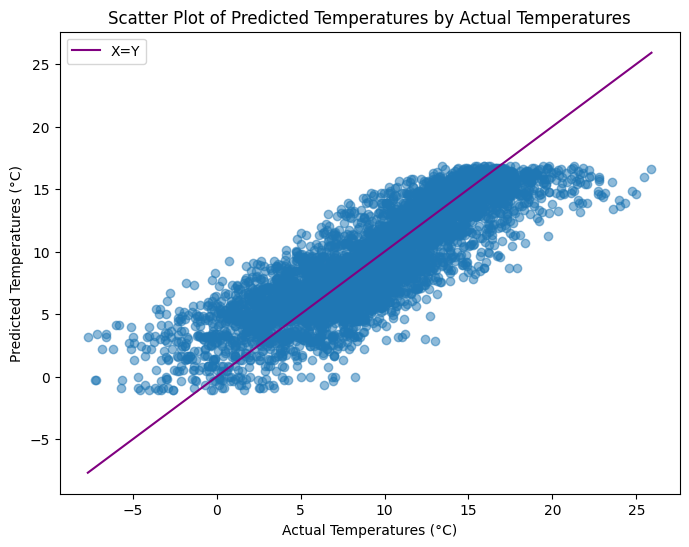

In [ ]:
# set figure size to 8x6
plt.figure(figsize=(8, 6))

# plot a scatter plot of actual temperature by predicted temperatures
# alpha=0.5 makes the points semi-transparent
plt.scatter(y_test, y_pred, alpha=0.5)

# label axis and title
plt.xlabel('Actual Temperatures (°C)')
plt.ylabel('Predicted Temperatures (°C)')
plt.title('Scatter Plot of Predicted Temperatures by Actual Temperatures')

# find minimum and maximum values from actual and predicted temperatures
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))

# plot a reference line where predicted temperatures match actual temperatures
plt.plot([min_val, max_val], [min_val, max_val], color='purple', label='X=Y')

# add a legend
plt.legend()

# display
plt.show()

# Part Two - New Points

In [ ]:
# load the excel file into a dataframe and remove the 'OBJECTID' column
random_points = pd.read_excel('random_points_covariates.xls').drop('OBJECTID', axis=1)

In [ ]:
# apply classify land cover function - classifies land cover into five cateogies
random_points['lc'] = random_points['lc'].apply(classify_landcover)

# define a function to classify years
def classify_year(yr_value):
    if 1 == yr_value:
        return 2019
    elif 2 == yr_value:
        return 2020
    elif 3 == yr_value:
        return 2021
    elif 4 == yr_value:
        return 2022
    else:
    # No data
        return 0

# apply year to random_points dataframe
random_points['year'] = random_points['year'].apply(classify_year)

# define a function to classify seasons based on the month
def classify_season(mth_value):
    # spring
    if 3 <= mth_value <= 5:
        return 2
    # summer
    if 6 <= mth_value <= 8:
        return 3
    # autumn
    if 9 <= mth_value <= 11:
        return 4
    # winter
    else:
        return 1

# apply season to random_points dataframe
random_points['season'] = random_points['month'].apply(classify_season)

## Apply Model

In [ ]:
# select relevant columns from the random_points dataframe for prediction
X_new = random_points[['lat', 'long', 'month', 'year', 'lc', 'gdft', 'hurs', 'pv', 'dem']]

# seperate features into those that need to be scaled and those that do not
features_to_scale_new = X_new[['gdft', 'hurs', 'pv', 'dem']]
features_not_to_scale_new = X_new[['lat', 'long', 'month', 'year', 'lc']]

# apply the scaler to features that need to be scaled
X_new_scaled_part = scaler.transform(features_to_scale_new)

# combine the scaled and non-scaled features
X_new_combined = np.hstack([X_new_scaled_part, features_not_to_scale_new.drop(columns=['lat', 'long', 'month', 'year']).values])

# use the trained SVR model to make predictions
y_pred_new = svm_model.predict(X_new_combined)

# update random_points dataframe with new predictions in 'air_temperature' column
random_points['air_temperature'] = y_pred_new

# rename dataframe to pred_temp
pred_temp = random_points

# display
pred_temp

,long,lat,month,year,dem,lc,gdft,hurs,pv,season,air_temperature
0,-2.774309,54.320268,12,2022,154.061890,3,19.952110,89.616441,6.873537,1,2.903460
1,-2.917279,54.290027,12,2022,204.045883,2,20.685508,89.561084,6.947481,1,2.558724
2,-3.125392,54.416281,12,2022,468.396851,3,17.707050,88.243902,6.459556,1,1.722558
3,-3.249922,54.456354,12,2022,225.673630,2,19.066842,87.754977,6.656980,1,2.692391
4,-2.793920,54.399373,12,2022,408.218079,3,17.905979,89.851733,6.605682,1,2.013177
...,...,...,...,...,...,...,...,...,...,...,...
8107,-3.070090,54.514399,1,2019,330.917664,3,17.481404,85.411396,6.493487,1,2.891998
8108,-2.877267,54.616777,1,2019,257.103729,2,17.156604,85.373762,6.713729,1,3.517311
8109,-2.959647,54.594016,1,2019,456.935394,3,17.689869,85.224287,6.565368,1,2.475809
8110,-2.945634,54.644928,1,2019,298.800507,3,17.293181,85.353791,6.775495,1,3.418462


In [ ]:
# calculate yearly average of predicted air temperatures
avg_temp = pred_temp.groupby(['year'])['air_temperature'].mean().reset_index()

# calculate yearly standard deviation of predicted air temperatures
std_temp = pred_temp.groupby(['year'])['air_temperature'].std().reset_index()

In [ ]:
# display yearly average of predicted air temperatures
avg_temp

,year,air_temperature
0,2019,8.577675
1,2020,8.838162
2,2021,8.592085
3,2022,9.140612


In [ ]:
# display yearly standard deviation of predicted air temperatures
std_temp

,year,air_temperature
0,2019,3.905131
1,2020,3.639252
2,2021,4.443755
3,2022,4.045464


##  Figure 6.7. Scatter plot exploring the relationship between elevation and air temperature by land cover based on average seasonal predicted temperature.

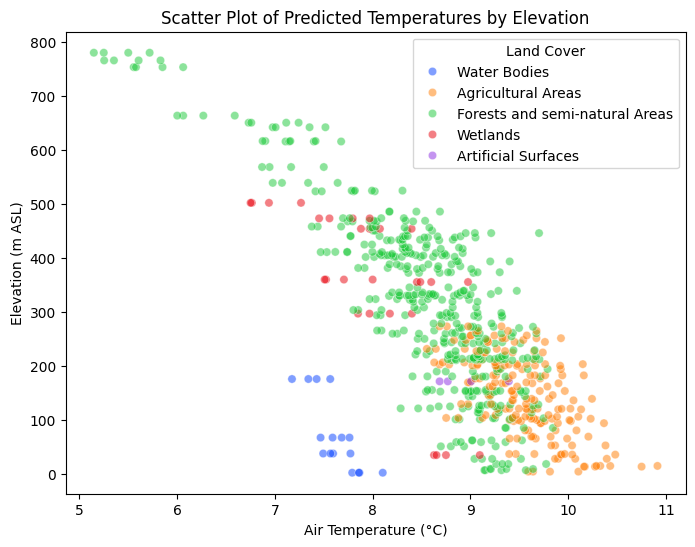

In [ ]:
# group by 'dem', 'year' and 'lc' and compute mean 'air_temperature'
dem_avg_temp = pred_temp.groupby(['dem', 'year', 'lc'])['air_temperature'].mean().reset_index()

# replace land cover codes with the code names
dem_avg_temp['lc'] = dem_avg_temp['lc'].replace([1, 2, 3, 4, 5], ['Artificial Surfaces', 'Agricultural Areas', 'Forests and semi-natural Areas', 'Wetlands', 'Water Bodies'])

# set figure size to 8x6
plt.figure(figsize=(8, 6))

# create a scatter plot to visualise the relationship between air temperature and elevation
# points are coloured by land cover type using 'hue' parameter
sns.scatterplot(x='air_temperature', y='dem', hue='lc', palette='bright', data=dem_avg_temp, alpha=0.5)

# label axis, title and legend
plt.xlabel('Air Temperature (°C)')
plt.ylabel('Elevation (m ASL)')
plt.title('Scatter Plot of Predicted Temperatures by Elevation')
plt.legend(title='Land Cover')

# display
plt.show()

## Figure 6.8. Time-series graph displaying the average, maximum, minimum, standard deviation and trendline of monthly predicted air temperatures.

In [ ]:
#------------ Average Air Temperature ------------

# calculate the average air temperature for each year and month
monthly_avg_temp = pred_temp.groupby(['year', 'month'])['air_temperature'].mean().reset_index()

# create a datetime column combining 'year' and 'month' as a string
monthly_avg_temp['date'] = pd.to_datetime(monthly_avg_temp['year'].astype(str) + '-' + monthly_avg_temp['month'].astype(str))

# set 'date' as the index
monthly_avg_temp.set_index('date', inplace=True)

#------------ Maximum Air Temperature ------------

# calculate the maximum air temperature for each year and month
monthly_max_temp = pred_temp.groupby(['year', 'month'])['air_temperature'].max().reset_index()

# create a datetime column combining 'year' and 'month' as a string
monthly_max_temp['date'] = pd.to_datetime(monthly_max_temp['year'].astype(str) + '-' + monthly_max_temp['month'].astype(str))

# set 'date' as the index
monthly_max_temp.set_index('date', inplace=True)

#------------ Minimum Air Temperature ------------

# calculate the minimum air temperature for each year and month
monthly_min_temp = pred_temp.groupby(['year', 'month'])['air_temperature'].min().reset_index()

# create a datetime column combining 'year' and 'month' as a string
monthly_min_temp['date'] = pd.to_datetime(monthly_min_temp['year'].astype(str) + '-' + monthly_min_temp['month'].astype(str))

# set 'date' as the index
monthly_min_temp.set_index('date', inplace=True)

#------------ Standard Deviation of Air Temperature ------------

# calculate the standard deviation of air temperature for each year and month
monthly_std_temp = pred_temp.groupby(['year', 'month'])['air_temperature'].std().reset_index()

# create a datetime column combining 'year' and 'month' as a string
monthly_std_temp['date'] = pd.to_datetime(monthly_std_temp['year'].astype(str) + '-' + monthly_std_temp['month'].astype(str))

# set 'date' as the index
monthly_std_temp.set_index('date', inplace=True)

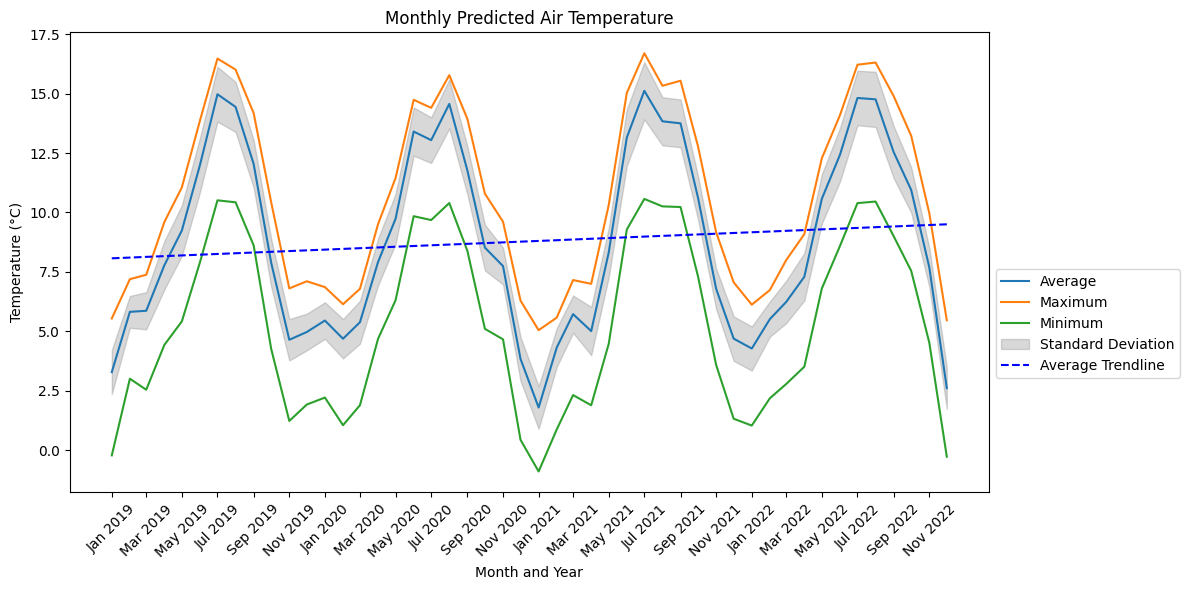

In [ ]:
# set figure size to 12x6
plt.figure(figsize=(12, 6))

# plot average air temperature
plt.plot(monthly_avg_temp.index, monthly_avg_temp['air_temperature'], label='Average')
# plot maximum air temperature
plt.plot(monthly_max_temp.index, monthly_max_temp['air_temperature'], label='Maximum')
# plot minimum air temperature
plt.plot(monthly_min_temp.index, monthly_min_temp['air_temperature'], label='Minimum')

# create a shaded region representing the standard deviation around the average
plt.fill_between(monthly_avg_temp.index,
                 monthly_avg_temp['air_temperature'] - monthly_std_temp['air_temperature'],
                 monthly_avg_temp['air_temperature'] + monthly_std_temp['air_temperature'],
                 color='grey', alpha=0.3, label='Standard Deviation')

# calculate a linear trendling for average air temeprature
x = np.arange(len(monthly_avg_temp))
y = monthly_avg_temp['air_temperature']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
# plot the trendline
plt.plot(monthly_avg_temp.index, p(x), "b--", label='Average Trendline')

# set the x-axis to display every 2nd month for better readability
ticks_to_use = monthly_avg_temp.index[::2]
plt.xticks(ticks_to_use, ticks_to_use.strftime('%b %Y'), rotation=45)

# label axis, title and legend
plt.title('Monthly Predicted Air Temperature')
plt.ylabel('Temperature (°C)')
plt.xlabel('Month and Year')
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

# adjust the layout
plt.tight_layout()

#display
plt.show()